In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import sys
import os
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.mecanum_calculations import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *

# %matplotlib widget
# import ipywidgets as widgets

In [2]:
_parent_folder = "cam_and_sensor_Feb_1_2023_5cm"
_folder_name = "sk22_30_random_slow"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "..","recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\simulation\\..\\recording_programs\\test_data\\cam_and_sensor_Feb_1_2023_5cm'

In [3]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# rename columns
_sk_df.rename(columns={"rust_time": "time"}, inplace=True)
_sk_df

,sys_time,time,e_fr,e_fl,e_rr,e_rl,rtc,mils,sync,ax,ay,az,gx,gy,gz
0,2023-02-01 15:23:18.256830,2023-02-01 15:23:18.257055,11948,-1995,-5300,7160,2023-02-01 08.53.17.000000 PM,3308838,0,-0.014194,0.015583,1.005208,-0.061038,0.148245,0.261129
1,2023-02-01 15:23:18.426830,2023-02-01 15:23:18.427197,11948,-1995,-5300,7160,2023-02-01 08.53.17.000000 PM,3308848,0,-0.009799,0.023151,0.998861,-0.152641,0.163512,0.215328
2,2023-02-01 15:23:18.427331,2023-02-01 15:23:18.427612,11948,-1995,-5300,7160,2023-02-01 08.53.17.000000 PM,3308859,0,-0.015903,0.020466,1.006185,-0.152641,0.087176,0.138992
3,2023-02-01 15:23:18.427830,2023-02-01 15:23:18.427965,11948,-1995,-5300,7160,2023-02-01 08.53.17.000000 PM,3308869,0,-0.013461,0.019245,1.002279,-0.091572,0.102443,0.261129
4,2023-02-01 15:23:18.428330,2023-02-01 15:23:18.428360,11948,-1995,-5300,7160,2023-02-01 08.53.17.000000 PM,3308879,0,-0.008823,0.015583,1.002523,0.030566,-0.004427,0.062656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5763,2023-02-01 15:24:18.302150,2023-02-01 15:24:18.302328,17319,-2682,-7191,11705,2023-02-01 08.54.17.000000 PM,3368883,1,-0.004184,0.018513,1.007406,-0.091572,0.087176,0.001588
5764,2023-02-01 15:24:18.312650,2023-02-01 15:24:18.312723,17319,-2682,-7191,11705,2023-02-01 08.54.17.000000 PM,3368893,1,-0.010043,0.018269,1.012533,-0.076305,0.194046,0.016855
5765,2023-02-01 15:24:18.323151,2023-02-01 15:24:18.323186,17319,-2682,-7191,11705,2023-02-01 08.54.17.000000 PM,3368903,1,-0.008823,0.015339,1.001791,0.030566,0.102443,0.108458
5766,2023-02-01 15:24:18.333657,2023-02-01 15:24:18.334113,17319,-2682,-7191,11705,2023-02-01 08.54.17.000000 PM,3368914,1,-0.000766,0.012653,1.007406,-0.061038,0.041374,0.001588


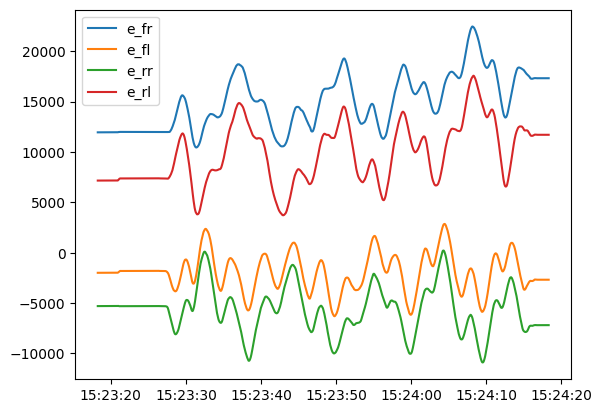

In [4]:
plt.plot(_sk_df["time"], _sk_df["e_fr"], label="e_fr")
plt.plot(_sk_df["time"], _sk_df["e_fl"], label="e_fl")
plt.plot(_sk_df["time"], _sk_df["e_rr"], label="e_rr")
plt.plot(_sk_df["time"], _sk_df["e_rl"], label="e_rl")
plt.legend()


In [5]:
radius = 47.5/1000
lx = 79 #half of the distance between the wheels
ly = 122.5/2

df = _sk_df.copy()
df = set_zero(df)
df, ang_col = get_angular_velocity(df, ang_per_increment=0.09, del_t=0.01)
df, vel_col = get_directional_velocity(df, ang_col, radius=radius, lx = lx, ly = ly)
df, col_names = get_position(df)
df, _ang_name = get_orientation(df)


In [6]:
# mocap data
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

# type in marker details
_xm = get_marker_name(2)
_ym = get_marker_name(8)
_om = get_marker_name(1)

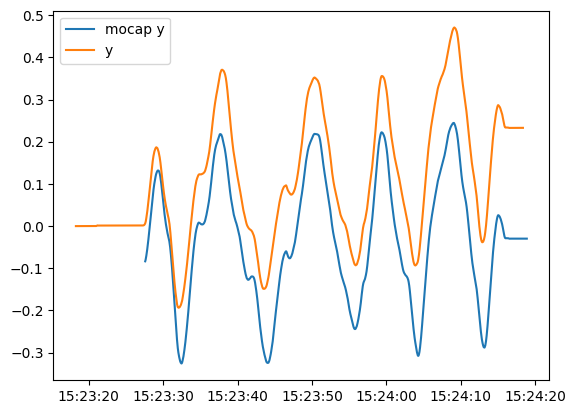

In [7]:
# plt.plot(_mocap_df.m2_x, label="x")
plt.plot(_mocap_df.time, _mocap_df[_om["x"]], label="mocap y")
plt.plot(df.time, df["y_val"], label="y")

# plt.plot(df["w"], label="theta")
plt.legend()

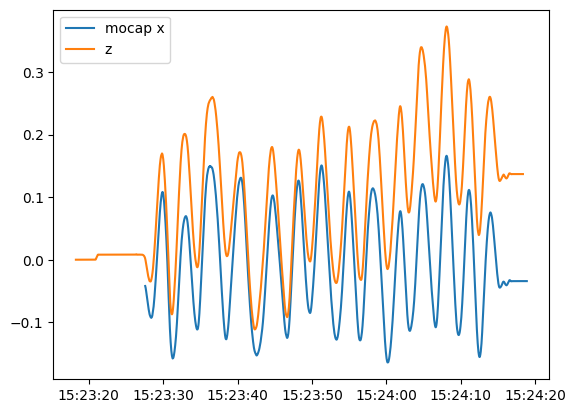

In [8]:
# plt.plot(_mocap_df.m2_x, label="x")
plt.plot(_mocap_df.time, _mocap_df[_om["z"]], label="mocap x")
plt.plot(df.time, df["x_val"], label="z")

# plt.plot(df["w"], label="theta")
plt.legend()

In [9]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

yvec = [_mocap_df[_ym["x"]].iloc[0], _mocap_df[_ym["y"]].iloc[0], _mocap_df[_ym["z"]].iloc[0]]
yvec = np.array(yvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = yvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vycap = v2 - (vxnorm.T @ v2) * vxnorm
vynorm = vycap / np.linalg.norm(vycap)

vznorm = np.cross(vynorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [10]:
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})

# apply rotation matrix
for i in range(len(_mc_df)):
    _mc_df.iloc[i, 1:] = (rotMat.T @ (_mc_df.iloc[i, 1:].values.reshape(3,1) - org)).T[0]


In [11]:
# rotate along y axis
# _mc_df["x"] = _mc_df["x"] * np.cos(np.deg2rad(90)) - _mc_df["z"] * np.sin(np.deg2rad(90))

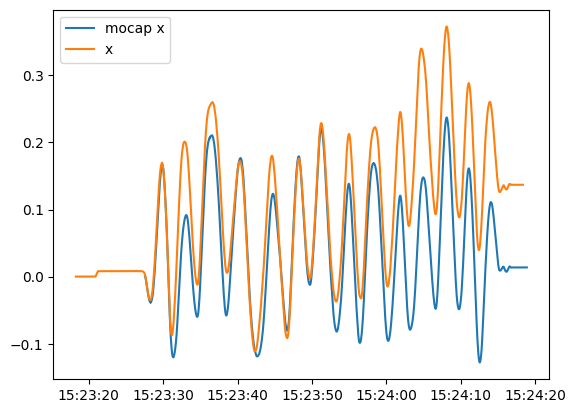

In [12]:
plt.plot(_mocap_df.time, _mc_df.y, label="mocap x")
plt.plot(df.time, df["x_val"], label="x")

# plt.plot(df["w"], label="theta")
plt.legend()

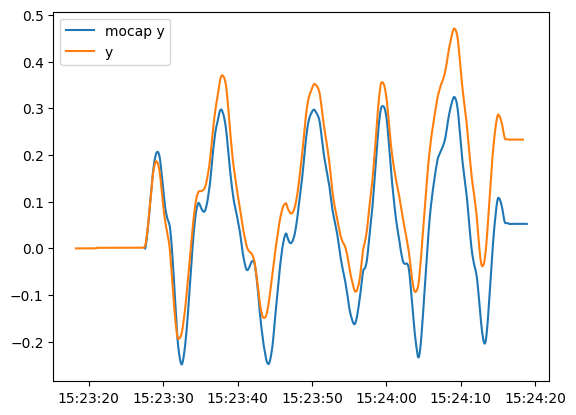

In [13]:
# plt.plot(_mocap_df.m2_x, label="x")
plt.plot(_mocap_df.time, -_mc_df.x, label="mocap y")
plt.plot(df.time, df["y_val"], label="y")

# plt.plot(df["w"], label="theta")
plt.legend()

In [14]:
# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_rotmat_i = []
for i in range(len(_m_df)):
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]].loc[i].values
    _x_vec = np.reshape(_x_vec, (3,1))
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]].loc[i].values
    _org = np.reshape(_org, (3,1))
    _y_vec = _m_df[[_ym["x"], _ym["y"], _ym["z"]]].loc[i].values
    _y_vec = np.reshape(_y_vec, (3,1))
    _rotmat_i.append(calculate_rotmat_from_xyo(_x_vec, _y_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in range(len(_rotmat_i)):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in _del_r:
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)

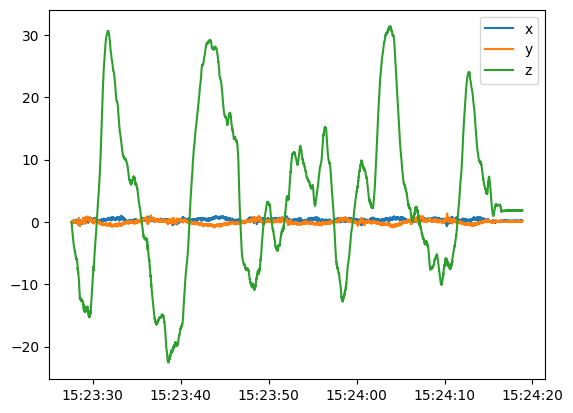

In [15]:
# plt.plot(df.time, np.rad2deg(df["theta"]), label="y")
plt.plot(_m_df.time, _theta_x, label="x")
plt.plot(_m_df.time, _theta_y, label="y")
plt.plot(_m_df.time, _theta_z, label="z")
plt.legend()


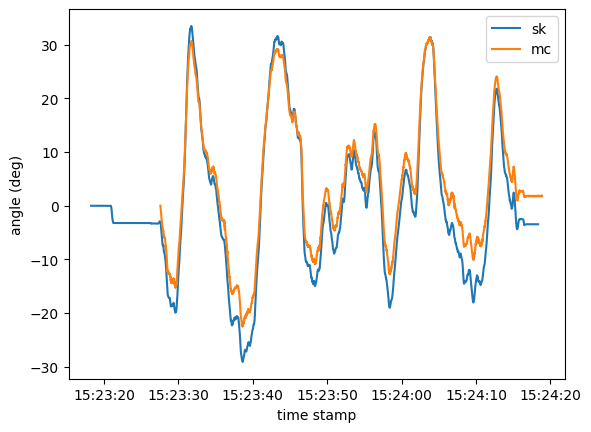

In [16]:
plt.plot(df.time, np.rad2deg(df["theta"])*600, label="sk")
plt.plot(_m_df.time, _theta_z, label="mc")
plt.ylabel("angle (deg)")
plt.xlabel("time stamp")
plt.legend()